In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

np.random.seed(42)

In [67]:
df = pd.read_csv("data/Inventory_Waste_CompanyData.csv")

In [68]:
le = LabelEncoder()
df["material_encoded"] = le.fit_transform(df["Material Type"])  # GI = 0, PI = 1
df["cost_per_sqm"] = df["Material Cost (AED)"] / df["Area (sq/m)"]

features = ["material_encoded", "Area (sq/m)", "Thickness (mm)", "Material Cost (AED)", "cost_per_sqm"]
target   = "Waste Cost (AED)"

In [69]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features].values)

knn = KNeighborsRegressor(n_neighbors=5, weights="distance", metric="euclidean")
knn.fit(X_scaled, df[target].values)

KNeighborsRegressor(metric='euclidean', weights='distance')

In [70]:
# function to lookup similar jobs

def similar_jobs(new_job: dict, k: int = 5):
    row = pd.DataFrame([{
        "material_encoded": le.transform([new_job["Material Type"]])[0],
        "Area (sq/m)": new_job["Area (sq/m)"],
        "Thickness (mm)": new_job["Thickness (mm)"],
        "Material Cost (AED)": new_job["Material Cost (AED)"],
        "cost_per_sqm": new_job["Material Cost (AED)"] / new_job["Area (sq/m)"],
    }])
    row_scaled = scaler.transform(row.values)

    distances, indices = knn.kneighbors(row_scaled, n_neighbors=k)

    similar = df.iloc[indices[0]].copy()
    similar["distance"]   = distances[0].round(4)
    similar["similarity"] = (1 / (1 + similar["distance"])).round(4)

    weights = 1 / (distances[0] + 1e-9)
    predicted_wp = np.dot(weights, df.iloc[indices[0]]["Waste Percentage"].values) / weights.sum()
    predicted_wc = new_job["Material Cost (AED)"] * predicted_wp

    cols = ["Job ID", "Material Type", "Area (sq/m)", "Thickness (mm)", "Material Cost (AED)", "Waste Percentage", "Waste Cost (AED)", "distance", "similarity"]
    return similar[cols].reset_index(drop=True), round(predicted_wp, 4), round(predicted_wc, 2)

In [71]:
# testing job lookup

new_job = {"Material Type": "GI", 
           "Area (sq/m)": 10.0,
           "Thickness (mm)": 20, 
           "Material Cost (AED)": 100.0}

similar, pred_wp, pred_wc = similar_jobs(new_job, k=5)

print(f"Predicted Waste %  : {pred_wp * 100:.2f}%")
print(f"Predicted Waste AED: {pred_wc:.2f}")
similar

Predicted Waste %  : 5.00%
Predicted Waste AED: 5.00


,Job ID,Material Type,Area (sq/m),Thickness (mm),Material Cost (AED),Waste Percentage,Waste Cost (AED),distance,similarity
0,JOB_1344,GI,9.62,0.56,139.49,0.05,6.97,2.069,0.3258
1,JOB_1259,GI,9.64,0.56,139.78,0.05,6.99,2.069,0.3258
2,JOB_1224,GI,9.33,0.56,135.31,0.05,6.77,2.069,0.3258
3,JOB_1817,GI,9.61,0.56,139.36,0.05,6.97,2.069,0.3258
4,JOB_1421,GI,9.22,0.56,133.71,0.05,6.69,2.069,0.3258


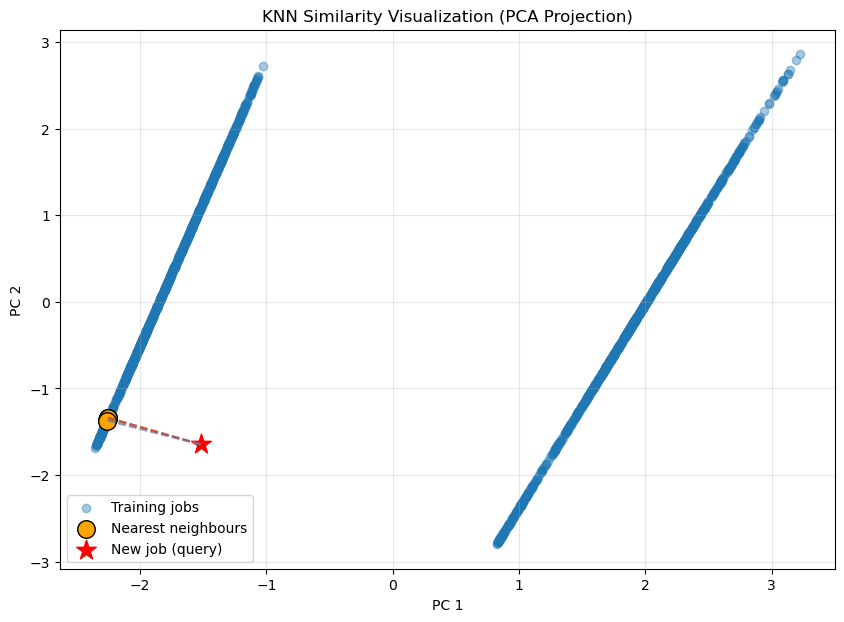

In [ ]:
# visualize knn using pca

query_df = pd.DataFrame([new_job])

query_df["material_encoded"] = le.transform(query_df["Material Type"])
query_df["cost_per_sqm"] = (
    query_df["Material Cost (AED)"] / query_df["Area (sq/m)"]
)

query_input = query_df[features]
query_scaled = scaler.transform(query_input)
distances, indices = knn.kneighbors(query_scaled)
neighbours = df.iloc[indices[0]]

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

query_2d = pca.transform(query_scaled)
neigh_scaled = scaler.transform(neighbours[features])
neigh_2d = pca.transform(neigh_scaled)

plt.figure(figsize=(10,7))
plt.scatter(X_2d[:,0], X_2d[:,1],
            alpha=0.4, label="Training jobs")
plt.scatter(neigh_2d[:,0], neigh_2d[:,1],
            s=160, color="orange", edgecolor="black",
            label="Nearest neighbours")
plt.scatter(query_2d[:,0], query_2d[:,1],
            s=220, marker="*", color="red",
            label="New job (query)")

for pt in neigh_2d:
    plt.plot([query_2d[0,0], pt[0]],
             [query_2d[0,1], pt[1]],
             linestyle="--", alpha=0.6)

plt.title("KNN Similarity Visualization (PCA Projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()